# Second Exercise
Implement **ISOMAP**, project the data set into 2D and color by label

In [23]:
# Importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from sklearn.preprocessing import KernelCenterer
from scipy.sparse.linalg import eigsh, eigs
import time
sns.set_theme()

In [24]:
# Importing the dataset
N = 500  # number of datapoints extracted

df_X = pd.read_csv("Unsupervised-Learning-Datasets-main/data_kPCA.txt", sep=" ", header=None).drop(10,axis=1)
X = df_X.values[0:n_points]
n_features = X.shape[1]
df_X.head()

,0,1,2,3,4,5,6,7,8,9
0,-9.950660,-4.417700,0.007956,6.630160,-0.281363,-0.187473,0.525670,-27.901300,-8.253580,0.000631
1,-8.465530,0.746013,-0.602208,-2.513050,2.257880,-0.670265,1.733490,-21.894200,0.572752,-0.415401
2,0.253353,-0.016910,-4.777830,-0.065455,-1.100220,0.284246,0.127176,0.113354,-0.001955,-9.283100
3,0.390241,-0.279857,0.798763,-0.330472,0.558310,-0.472800,-0.262537,0.216694,-0.131599,0.634563
4,-8.274680,-4.399440,-0.716388,6.033570,2.434720,1.775300,-4.539370,-21.158000,-8.202450,-0.538976


In [25]:
df_y = pd.read_csv("Unsupervised-Learning-Datasets-main/labels_kPCA.txt", sep=" ", header=None)
df_y.columns = ["label"]
y = df_y.values[0:N]
df_y.head()

,label
0,0
1,3
2,3
3,2
4,0


In [26]:
# Concatenating the two dataframes
df = pd.concat([df_X, df_y], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,label
0,-9.950660,-4.417700,0.007956,6.630160,-0.281363,-0.187473,0.525670,-27.901300,-8.253580,0.000631,0
1,-8.465530,0.746013,-0.602208,-2.513050,2.257880,-0.670265,1.733490,-21.894200,0.572752,-0.415401,3
2,0.253353,-0.016910,-4.777830,-0.065455,-1.100220,0.284246,0.127176,0.113354,-0.001955,-9.283100,3
3,0.390241,-0.279857,0.798763,-0.330472,0.558310,-0.472800,-0.262537,0.216694,-0.131599,0.634563,2
4,-8.274680,-4.399440,-0.716388,6.033570,2.434720,1.775300,-4.539370,-21.158000,-8.202450,-0.538976,0


## 1. Data Preprocessing
Preprocess the data in the first file by centering the variables and divide them by their standard deviation.

In [27]:
# Standardizing dataset
std = X.std(axis=0)
mean = X.mean(axis=0)
X = (X-mean)/std

## ISOMAP
Implementing Isomap algorithm

In [6]:
# Distance matrix (euclidean distance between points)
dist = distance_matrix(X, X, p=2)

In [7]:
# Computing the average distance from the 5-th nearest neighbor of each datapoint
dist5_mean = 0
for i in range(N):
    dist_ordered = np.sort(dist[i,:])
    # dist_ordered[5] is the distance to the fifth nearest-neighbor since the array includes the distance with itslef (which is zero)
    dist5_mean = dist5_mean + dist_ordered[5]

dist5_mean = dist5_mean/N

In [33]:
# I create a matrix delta_ij in which each element ij is equal to dist[i,j] if d[i,j]<dc, and otherwise it is equal to infinity
dc = 10*dist5_mean  # critical lower distance
delta = np.where(dist<dc, dist, np.Inf)

In [34]:
# Implementation of FLOYD algorithm
start = time.time()
for k in range(N):
    for j in range(N):
        for i in range(N):
            if(delta[i,j]>delta[i,k]+delta[k,j]):
                delta[i,j] = delta[i,k]+delta[k,j]
print("---Elapsed time: ", time.time()-start)

---Elapsed time:  104.70368885993958


In [35]:
# Are still there Inf values?
np.sum(np.isinf(delta))

0

In [36]:
# Centering
I = np.identity(N)
J_N = np.ones(N)/N
H = I-J_N

G = -0.5*(H @ delta**2 @ H)

In [56]:
# Computing the first 10 eigenvalues and eigenvectors of the Gram matrix
eig_values, eig_vectors = eigsh(G, 10, which="LM")
eig_values

array([-269.62648122, -166.98352713, -113.33752549,  116.75455684,
        173.44586436,  235.82644464,  399.45157303, 1024.04293253,
       1838.09761566, 2215.41814038])

In [57]:
# Sorting eigenvalues and eigenvectors
index_sort = np.argsort(eig_values)[::-1]  # getting indexes for sorting (eigenvalues in descending order)
eig_values = eig_values[index_sort]
eig_vectors = eig_vectors[:,index_sort]
eig_vectors = eig_vectors*np.sqrt(eig_values)
eig_vectors.shape

/tmp/ipykernel_38296/463834343.py:5: RuntimeWarning: invalid value encountered in sqrt
  eig_vectors = eig_vectors*np.sqrt(eig_values)


(500, 10)

In [58]:
X_isomap = eig_vectors.copy()
# creating dataframe with projected features
df_isomap = pd.DataFrame(X_isomap, columns=["PC_iso"+str(i+1) for i in range(n_features)])
df_isomap[["label"]] = y.reshape((N,1))
df_isomap.head()

,PC_iso1,PC_iso2,PC_iso3,PC_iso4,PC_iso5,PC_iso6,PC_iso7,PC_iso8,PC_iso9,PC_iso10,label
0,-5.437914,3.321946,-0.401593,-0.447802,0.809893,1.159885,0.236725,NaN,NaN,NaN,0
1,-2.165592,1.011583,-2.212034,-3.025152,-0.582877,0.920503,0.823911,NaN,NaN,NaN,3
2,1.567851,-0.708926,-1.419604,0.011152,-0.605498,-1.267751,-0.119548,NaN,NaN,NaN,3
3,-0.483566,-1.092165,-0.503753,0.509258,0.746155,0.553278,0.194921,NaN,NaN,NaN,2
4,-2.539764,4.386059,-0.939510,0.372467,-0.069980,-0.634615,0.309589,NaN,NaN,NaN,0


Text(0, 0.5, '$\\lambda$')

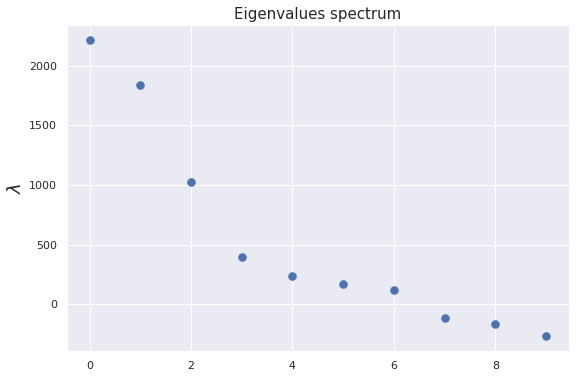

In [59]:
# Plotting eigenvalues
plt.subplots(figsize=(9,6))
plt.plot(eig_values,'.',markersize=15)
plt.title('Eigenvalues spectrum', fontsize=15)
plt.ylabel(r'$\lambda$', fontsize=18)
# plt.yscale('log')

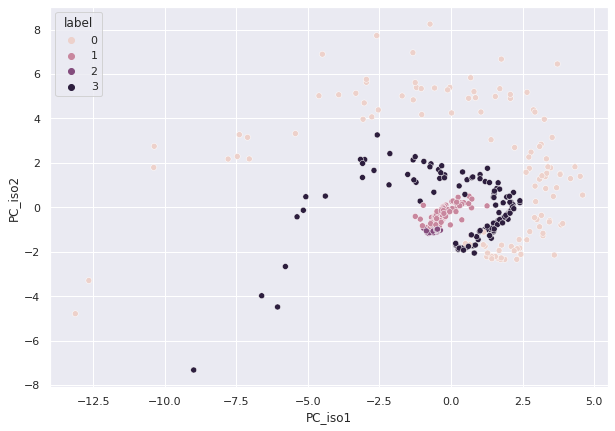

In [61]:
# Plot first two PCs, coloring data points by family
plt.subplots(figsize=(10,7))
sns.scatterplot(x="PC_iso1", y="PC_iso2", data=df_isomap, hue="label")
plt.show()

-----
## ISOMAP with scikit-learn

In [42]:
from sklearn.manifold import Isomap

In [43]:
embedding = Isomap(n_components=10, path_method="FW")
X_iso_skl = embedding.fit_transform(X)

In [44]:
# creating dataframe with projected features
df_isomap = pd.DataFrame(X_iso_skl, columns=["PC_iso"+str(i+1) for i in range(n_features)])
df_isomap[["label"]] = y.reshape((N,1))
df_isomap.head()

,PC_iso1,PC_iso2,PC_iso3,PC_iso4,PC_iso5,PC_iso6,PC_iso7,PC_iso8,PC_iso9,PC_iso10,label
0,16.957936,-1.783810,-0.884345,0.430076,1.952348,-1.640742,-0.586408,-0.420683,-0.630625,1.326939,0
1,11.772751,4.334431,-0.026892,-0.894869,1.151656,0.640159,-1.410502,-0.897772,0.945257,0.627925,3
2,3.292330,1.872334,0.842251,1.286526,0.007258,-0.357848,0.636531,-1.177063,0.061506,0.273395,3
3,-6.280935,0.409725,-1.707072,0.215868,-0.086592,-0.072842,-0.025874,-0.049773,0.042682,-0.017101,2
4,14.285082,-2.095994,-0.148696,-1.134364,0.286747,0.649179,-0.609259,-1.234837,0.803614,-0.593373,0


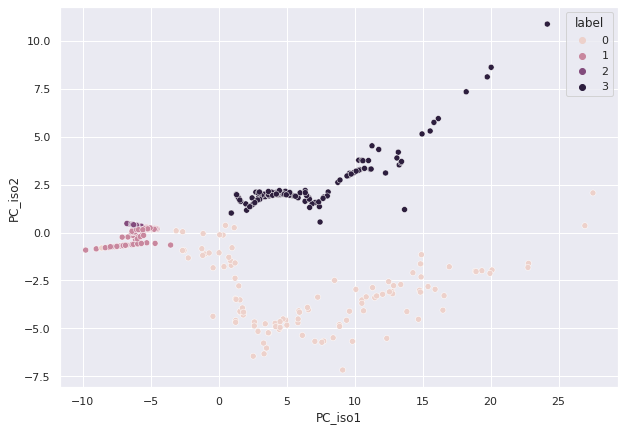

In [45]:
# Plot first two PCs, coloring data points by family
plt.subplots(figsize=(10,7))
sns.scatterplot(x="PC_iso1", y="PC_iso2", data=df_isomap, hue="label")
plt.show()